In [765]:
# Avantgarde Model
# p_a(s) = (1-a) s + a (1-s)

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams.update({'font.size': 14})

In [927]:
from scipy.spatial.distance import pdist, cdist


class State:
    # global state determined by microstates 
    # (position: (x, y), value: f)
    # and global N, L, r (neighbour radius)
    # a: float, 'discrete', 'continuous' (if float a global a is assigned to each agent)

    def __init__(self, N, L, r, a, seed=101, pareto=(4., 0.01)):
        self.N = N
        self.D = 2 # fixed
        self.L = L
        self.r = r
        self.a = a
        self._pareto = pareto # for adaptation probability
        self.seed = seed
        self.rng = np.random.default_rng(self.seed)
        a, m = self._pareto
        self.susceptibility = (self.rng.pareto(a, self.N) + 1) * m

    def populate(self, seed_fun, structure='grid'): # 'grid', 'random'
        # grid
        if structure == 'grid':
            nx = int(np.sqrt(self.N))
            if (nx * nx) != self.N:
                self.N = nx * nx
                print('Attention! State N was modified to match a square number.')
            x = np.linspace(0., self.L, nx)
            y = np.linspace(0., self.L, nx)
            xx, yy = np.meshgrid(x, y)
            self.locations = np.stack((xx, yy), axis=2).reshape((self.N, 2))
        ## random locations
        if structure == 'random':
            self.locations = self.rng.random((self.N, self.D)) * self.L
        self.f = np.zeros(self.N)
        self.s = np.zeros(self.N)
        self.estimate_neighbours()
        self.create_a()
        self.seed_s(seed_fun)
        
    def create_a(self):
        if type(self.a) == float: # global
            self.aval = np.ones(self.N) * self.a
        elif self.a == 'discrete':
            self.aval = self.rng.choice([0, 0.5, 1], size=self.N)
        elif self.a == 'continuous':
            self.aval = self.rng.random(size=self.N)
        
    def estimate_neighbours(self):
        self.neighbours = []
        for idx, loc in enumerate(self.locations):
            loc_neighbours = np.argwhere(cdist([loc], self.locations)[0] < self.r)
            self.neighbours.append([array[0] for array in loc_neighbours if array[0] != idx])
    
    def build(self, index):
        # build f at locations[index]
        # building means changing f from 0 -> 1
        if self.f[index] == 1:
            raise Exception(f'Error building at index {index}: F already build!')
        self.f[index] = 1
        self.update_s(index)
    
    def seed_s(self, seed_fun):
        indices = seed_fun(self)
        for j in indices:
            self.build(j)
    
    def update_s(self, index):
        for k in self.neighbours[index]:
            # increase the respective s
            n_neighbours = len(self.neighbours[k])
            self.s[k] += 1./n_neighbours
      
    @staticmethod
    def _check_point_inside_circle(px, py, cx, cy, r):
        dx = px - cx
        dy = py - cy
        return dx * dx + dy * dy < r * r
    
    @staticmethod
    def _select_rnd_center(locs, L):
        """ The center area is defined as a circle
        with radius x percent of L
        """
        centers = []
        p = 0
        while len(centers) < 1:
            p += 1
            r = p * 0.01 * L
            centers = [l for l in locs if State._check_point_inside_circle(l[0], l[1], L/2, L/2, r)]

        index = np.random.choice(np.arange(len(centers)))
        return centers[index]
        
    def show(self, figsize=(10, 10), mark=[], mark_neighbours=[], axis=None, plt_show=True):
        if not axis:
            fig = plt.figure(figsize=figsize)
            axis = fig.gca()
        
        x = self.locations[:, 0]
        y = self.locations[:, 1]
        
        s = 8
        axis.scatter(x[self.f == 0], y[self.f == 0], c='orange', s=s)
        axis.scatter(x[self.f == 1], y[self.f == 1], c='olive', s=s)
        
        for i in mark:    
            axis.scatter(x[i], y[i], s=s, facecolor='None', edgecolor='red')
        
        # iterate over locations for which
        # the neighbours are highlighted
        for i in mark_neighbours:
            for k in self.neighbours[i]:
                axis.scatter(x[k], y[k], s=s, facecolors='None', edgecolor='blue')
        
        if plt_show: plt.show()
        

def step(_state, spread_fun):
    # choose random point with s > 0
    indices = [array[0] for array in np.argwhere(np.logical_and(_state.s > 0, _state.f == 0))]
    if len(indices) < 1:
        return
    k = _state.rng.choice(indices)
    # build f with prob p(a, s(k))
    indices = spread_fun(k, _state)
    for index in indices:
        _state.build(index)
    return indices

# Avantgarde Model
* Network of ordered agents with connections to direct neighbours
* Seed one agent in the center
* s = N_s / N
* spread with prob. p(s)=(1-a)s + a(1-s)

In [846]:
def simpleSpreading(k, state):
    s = state.s[k]
    a = state.aval[k]
    p = (1-a) * s + a * (1-s)
    if state.rng.random() < p:
        return [k]
    return []

def seedSingleAgent(state):
    # get center location
    center = state._select_rnd_center(state.locations, state.L)
    cond0 = state.locations[:, 0] == center[0]
    cond1 = state.locations[:, 1] == center[1]
    center_i = np.argwhere(np.logical_and(cond0, cond1))[0][0]
    return [center_i]

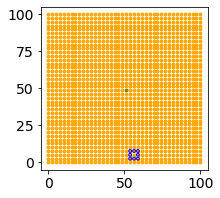

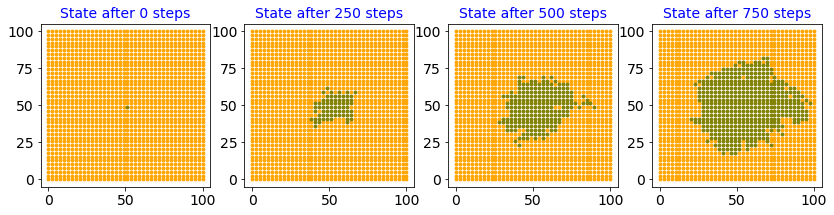

In [848]:
N, L, r, a = 1600, 100, 4, 0.0
simpleState = State(N, L, r, a, seed=102)
simpleState.populate(seedSingleAgent, structure='grid')
simpleState.show(figsize=(3, 3), mark_neighbours=[102])

fig, ax = plt.subplots(1, 4, figsize=(14, 3))
#densities = []
#counter = 1
for j in range(4):
    nsteps = j * 250
    for i in range(nsteps):
        counter += 1
        step(simpleState, simpleSpreading)
        if counter % 500 == 0:
            densities.append(density(m_state, area))
    simpleState.show(axis=ax.flatten()[j], plt_show=False)
    ax.flatten()[j].set_title(f'State after {nsteps} steps', fontsize=14, color='blue')
    
plt.show()

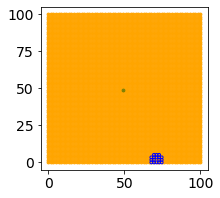

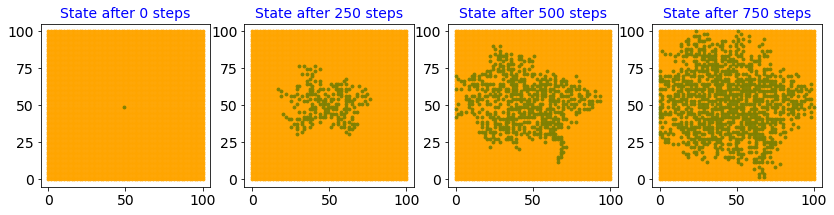

In [918]:
N, L, r, a = 3600, 100, 4, 1.0
simpleState = State(N, L, r, a, seed=102)
simpleState.populate(seedSingleAgent, structure='grid')
simpleState.show(figsize=(3, 3), mark_neighbours=[102])

fig, ax = plt.subplots(1, 4, figsize=(14, 3))
#densities = []
#counter = 1
for j in range(4):
    nsteps = j * 250
    for i in range(nsteps):
        counter += 1
        step(simpleState, simpleSpreading)
        if counter % 500 == 0:
            densities.append(density(m_state, area))
    simpleState.show(axis=ax.flatten()[j], plt_show=False)
    ax.flatten()[j].set_title(f'State after {nsteps} steps', fontsize=14, color='blue')
    
plt.show()

Evolution of state with N=3600 and a=0.0


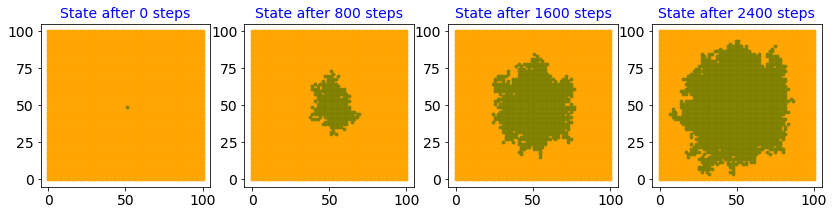

Evolution of state with N=3600 and a=0.5


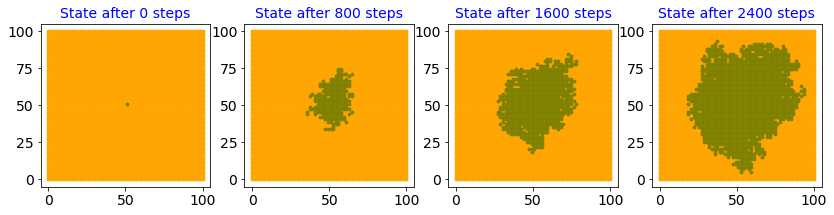

Evolution of state with N=3600 and a=1.0


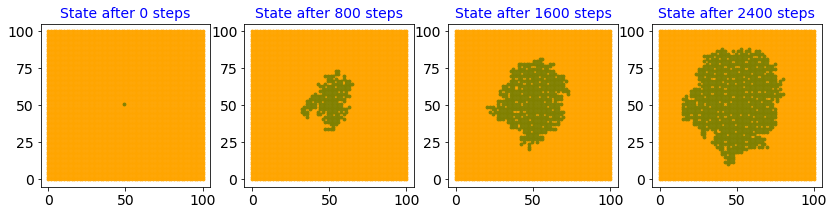

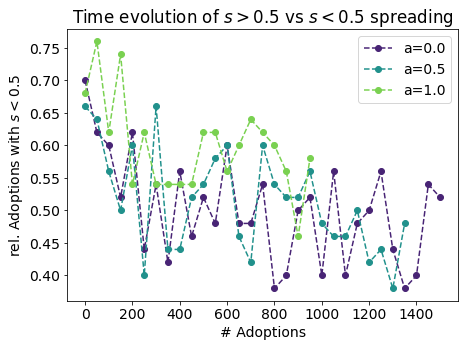

In [924]:
def sSpreading(k, state):
    s = state.s[k]
    a = state.aval[k]
    if s > 0.5:
        p = (1-a) * s + a * (1-s)
    else:
        p = s
    if state.rng.random() < p:
        return [k]
    return []

def main(a):
    N, L, r, = 3600, 100, 3
    simpleState = State(N, L, r, a, seed=104)
    simpleState.populate(seedSingleAgent, structure='grid')
    #simpleState.show(figsize=(3, 3), mark_neighbours=[102])
    
    print(f'Evolution of state with N={N} and a={a:.1f}')
    
    fig, ax = plt.subplots(1, 4, figsize=(14, 3))
    nSpreads = 0
    s = []
    tSpreads = []
    #densities = []
    counter = 1
    for j in range(4):
        nsteps = j * 800
        for i in range(nsteps):
            counter += 1
            indices = step(simpleState, sSpreading) # can only be one index
            if indices:
                s.append(simpleState.s[indices[0]])
                nSpreads += 1
            spreadsPerCount = 50
            if nSpreads >= spreadsPerCount:
                tSpreads.append(np.sum(np.array(s) < 0.5) / nSpreads)
                nSpreads = 0
                s = []
    #         if counter % 400 == 0:
    #             densities.append(density(m_state, area))
        simpleState.show(axis=ax.flatten()[j], plt_show=False)
        ax.flatten()[j].set_title(f'State after {nsteps} steps', fontsize=14, color='blue')
    
    plt.show()
    return np.arange(0, len(tSpreads)*spreadsPerCount, spreadsPerCount), tSpreads

cmap = mpl.cm.get_cmap('viridis')

a = (0.0, 0.5, 1.0)
x, y = [], []
for ai in a:
    xi, yi = main(ai)
    x.append(xi)
    y.append(yi)

plt.figure(figsize=(7, 5))
c = (cmap(0.1), cmap(0.5), cmap(0.8))
for ai, xi, yi, ci in zip(a, x, y, c):
    plt.plot(xi, yi, 'o--', color=ci, label=f'a={ai:.1f}')

plt.legend()
plt.title(r'Time evolution of $s>0.5$ vs $s<0.5$ spreading')
plt.xlabel('# Adoptions')
plt.ylabel(r'rel. Adoptions with $s < 0.5$')
plt.show()

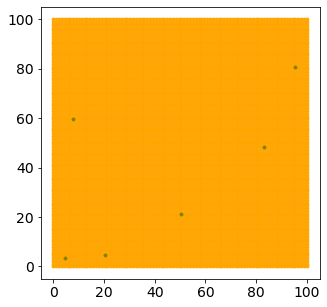

In [1072]:
def susceptibilitySpreading(k, _state):
    s = _state.s[k]
    if s < 0.5:
        p = 1./10 * _state.susceptibility[k] # eps * s
    else:
        p = (1-_state.aval[k]) * (2*s-1) + _state.aval[k] * 2 * (1-s)
        p *= _state.susceptibility[k]
    if _state.rng.random() < p:
        return [k]
    return []

def seedBySusceptibility(_state):
    isAdaptor = _state.rng.random(_state.N) < _state.susceptibility
    return np.argwhere(isAdaptor).flatten()


# create initial state
N, L, r = 8100, 100, 2
susState = State(N, L, r, 'continuous', seed=100, pareto=(1., 0.0001))
susState.susceptibility = (6./N) * np.ones(susState.N)
susState.populate(seedBySusceptibility, structure='grid')
susState.show(figsize=(5, 5))

0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5


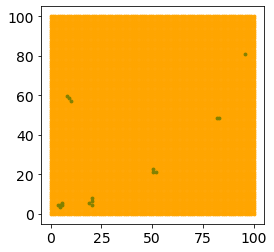

In [1049]:
for _ in range(10000): 
    step(susState, susceptibilitySpreading)
susState.show(figsize=(4, 4))

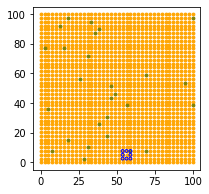

In [283]:
# create initial state
m_state = State(1600, 100, 4, 'continuous', seed=102)
m_state.populate(structure='grid')
m_state.show(figsize=(3, 3), mark_neighbours=[102])

In [5]:
def density(_state, area): # area [[x0, y0], [x1, y1]]
    xcond = np.logical_and(_state.locations[:, 0] > area[0][0], _state.locations[:, 0] < area[1][0])
    ycond = np.logical_and(_state.locations[:, 1] > area[0][1], _state.locations[:, 1] < area[1][1])
    f_select = _state.f[np.logical_and(xcond, ycond)]
    rho = np.sum(f_select) * 1./f_select.size
    return rho

In [6]:
area = [[25, 25], [75,75]]
density(m_state, area)

0.010226442658875092

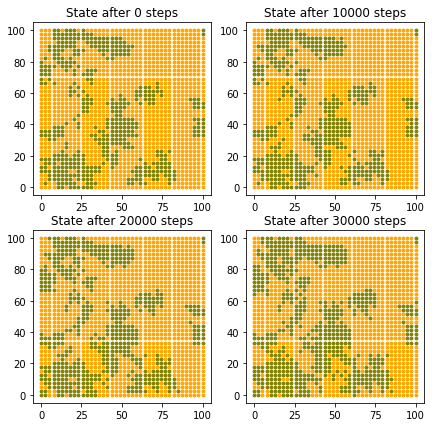

615.0

In [295]:
fig, ax = plt.subplots(2, 2, figsize=(7, 7))
#densities = []
#counter = 1
for j in range(4):
    nsteps = j * 10000
    for i in range(nsteps):
        counter += 1
        step(m_state)
        if counter % 200 == 0:
            densities.append(density(m_state, area))
    m_state.show(axis=ax.flatten()[j], plt_show=False)
    ax.flatten()[j].set_title(f'State after {nsteps} steps')
    
plt.show()
np.sum(m_state.f)

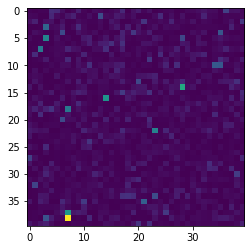

In [299]:
plt.figure()
npx = int(np.sqrt(m_state.N))
plt.imshow(m_state.susceptibility.reshape(npx, npx))
plt.show()

C:\Users\hoedtke\AppData\Local\Temp/ipykernel_12964/2933691786.py:18: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(eps), np.log10(corr_dim), 'x--')


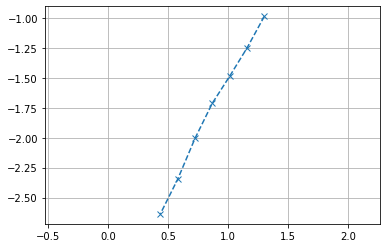

Fit results: m=nan, y0=nan


C:\Users\hoedtke\AppData\Local\Temp/ipykernel_12964/2933691786.py:23: RuntimeWarning: divide by zero encountered in log10
  m, y0 = np.polyfit(np.log10(eps[:]), np.log10(corr_dim), deg=1)


In [122]:
from scipy.spatial.distance import pdist

def grass_procaccia(N, locs, r):
    if N > 15000:
        raise Exception('Potential Mem Overload!')
    # Corr(r) = 2 / N (N-1) * Sum_i<j (Theta( r - d_ij ))
    pair_distances = pdist(locs)
    count = np.sum(np.heaviside(r - pair_distances, np.ones(int(N*(N-1)/2))))
    return 2.0 * count / (N*(N - 1))

m_points = m_state.locations[m_state.f == 1]
eps = np.logspace(np.log10(20), np.log10(1.), 10)
helper = lambda r: grass_procaccia(m_points.shape[0], m_points, r)
vec_procaccia = np.vectorize(helper)
corr_dim = vec_procaccia(eps)
    
plt.figure()
plt.plot(np.log10(eps), np.log10(corr_dim), 'x--')
plt.axis('equal')
plt.grid(True)
plt.show()

m, y0 = np.polyfit(np.log10(eps[:]), np.log10(corr_dim), deg=1)
print(f'Fit results: {m=:.2f}, {y0=:.2f}')

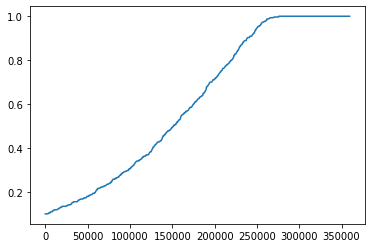

In [127]:
# State(22500, 100, 2., 0.5, seed=101) m=10
plt.figure()
plt.plot(np.arange(len(densities))*400, densities)

In [448]:
a = 1.0
print(np.roots([1-2*a, a]))
print(np.roots([1, -2*a, a]))
print(np.roots([1-2*a,a,-a,a]))

[1.]
[1. 1.]
[1.00000000e+00+0.j 7.77156117e-16+1.j 7.77156117e-16-1.j]


C:\Users\hoedtke\AppData\Local\Temp/ipykernel_19588/602990305.py:19: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


<Figure size 432x288 with 0 Axes>

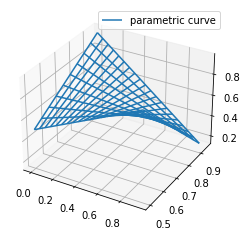

In [687]:
import matplotlib.pyplot as plt

plt.figure()

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

mpl.rcParams['legend.fontsize'] = 10

x,y = np.mgrid[0:1:0.05, 0.5:1:0.05]

#z = (1-x)**20 * y**9.4 + x**20*(1-y)**9.4
z = (1-x)*y + x*2*(1-y)


fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot_wireframe(x, y, z, label='parametric curve')
ax.legend()

plt.show()

In [20]:
rng = np.random.default_rng()
rng.choice([0, 1, 2], size=10)

array([1, 1, 2, 1, 1, 0, 1, 0, 2, 1])

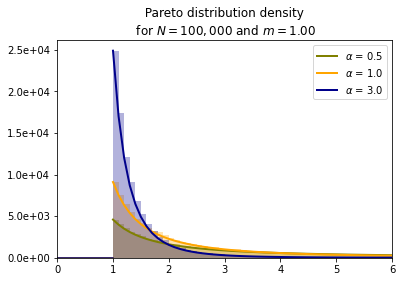

In [107]:
# --------------------------
# Pareto / Zipf distribution
# --------------------------
# m - lower bound
# a > 0, positive scaling parameter
# 
# f(X > m) = 1 - (m/X)^a 
#
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

N = int(1e5)

a_arr = (0.5, 1, 3)
colors = ( 'olive', 'orange', 'darkblue')
m = 1.

fig = plt.figure()

for a, c in zip(a_arr, colors):
    
    s = (np.random.default_rng().pareto(a, N) + 1) * m

    count, bins, _ = plt.hist(s, 50, range=(m, 6), density=False, alpha=0.3, color=c)
    fit = a*m**a / bins**(a+1)
    plt.plot(bins, max(count)*fit/max(fit), linewidth=2, color=c, label=fr'$\alpha$ = {a:.1f}')
    plt.plot([0, 1], [0, 0], color=c)

fmt = lambda x, pos: f'{x:.1e}'
plt.gca().yaxis.set_major_formatter(FuncFormatter(fmt))
plt.legend()
plt.xlim([m-1, 6])
plt.title(fr' Pareto distribution density ' + '\n' + fr' for $N={N:,d}$ and $m={m:.2f}$ ')
plt.show()

In [11]:
class Graph:
    
    def __init__(self, nrows, ncols, graph):
        self.ROW = nrows
        self.COL = ncols
        self.graph = graph
        
    def isSafe(self, rowN, colN):
        # rowN and colN in range
        # val is 1
        # place has not been visited
        return (0 <= rowN < self.ROW and
                0 <= colN < self.COL and
                self.graph[rowN][colN] and
                not self.visited[rowN][colN])
        
    def countIslands(self):
        
        # make boolean array
        self.visited = np.zeros((self.ROW, self.COL))
        
        islands = []
        for i in range(self.ROW):
            for j in range(self.COL):
                if (not self.visited[i][j] and
                    self.graph[i][j]):
                    size = self.DFS(i, j)
                    islands.append(size)
        
        return islands
    
    def DFS(self, i, j):
        
        # These arrays are used to get row and
        # column numbers of 8 neighbours
        # of a given cell
        rowNbr = [-1, -1, -1,  0, 0,  1, 1, 1];
        colNbr = [-1,  0,  1, -1, 1, -1, 0, 1];
         
        # Mark this cell as visited
        self.visited[i][j] = True
        size = 1
 
        # Recur for all connected neighbours
        for k in range(8):
            if self.isSafe(i + rowNbr[k], j + colNbr[k]):
                size += self.DFS(i + rowNbr[k], j + colNbr[k])
        
        return size
        

def count_islands(_state, inverse=True):
    
    # val which indicates island
    control_val = 0 if inverse else 1
    
    # transform 1d array f into 2d
    Nsite = int(np.sqrt(_state.N))
    transformed = _state.f.reshape((Nsite, Nsite)) == control_val
    
    row = len(transformed)
    col = len(transformed[0])

    g = Graph(row, col, transformed)
    islands = g.countIslands()
    
    print ("Number of islands is:")
    print (islands)
    
    return islands

Number of islands is:
[4, 12, 28, 2, 6, 4, 10, 17, 5, 5, 3, 14, 3, 4, 28, 3, 5, 5, 21, 7, 9, 7, 8, 26, 1, 5, 4, 2, 8, 10, 3, 16, 3, 15, 6, 4, 2, 9, 3, 7, 10, 28, 2, 6, 8, 1, 4, 3, 7, 3, 7, 3, 13, 14, 37, 2, 8, 3, 5, 3, 7, 5, 6, 4, 16, 1, 5, 1, 5, 3, 3, 2, 2, 2, 3, 8, 20, 7, 18, 2, 2, 5, 3, 4, 5, 6, 10, 15, 10, 1, 7, 9, 13, 7, 3, 2, 17, 11, 5, 20, 6, 2, 6, 17, 4, 18, 4, 5, 3, 6, 4, 16, 4, 6, 3, 12, 5, 9, 1, 11, 1, 3, 12, 1, 2, 4, 7, 4, 5, 4, 10, 16, 2, 1, 2, 3, 3, 22, 1, 9, 15, 12, 20, 7, 1, 9, 4, 6, 7, 8, 22, 9, 12, 6, 6, 4, 13, 6, 12, 12, 6, 5, 10, 3, 3, 21, 1, 7, 7, 4, 17, 8, 10, 2, 8, 4, 4, 3, 17, 4, 18, 4, 6, 4, 2, 7, 26, 6, 5, 6, 9, 7, 5, 5, 16, 3, 20, 3, 8, 2, 1, 5, 5, 2, 1]


C:\Users\hoedtke\AppData\Local\Temp/ipykernel_12032/2473310666.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(range(1, len(counts))), np.log10(counts[1:]), 'x--')


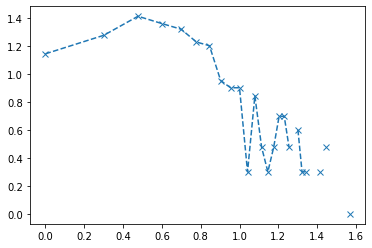

In [52]:
islands = count_islands(m_state, inverse=False)
counts = np.bincount(islands)
plt.figure()
plt.plot(np.log10(range(1, len(counts))), np.log10(counts[1:]), 'x--')

In [162]:
graph = [[1, 1, 0, 0, 0],
        [0, 1, 0, 0, 1],
        [1, 0, 1, 1, 1],
        [0, 0, 0, 0, 0],
        [1, 0, 1, 0, 1]]

row = len(graph)
col = len(graph[0])
 
g = Graph(row, col, graph)
 
print ("Number of islands is:")
print (g.countIslands())

Number of islands is:
[8, 1, 1, 1]


a, m = 2., 0.05  # shape and mode
self.rng.pareto(a, self.N) + 1) * m

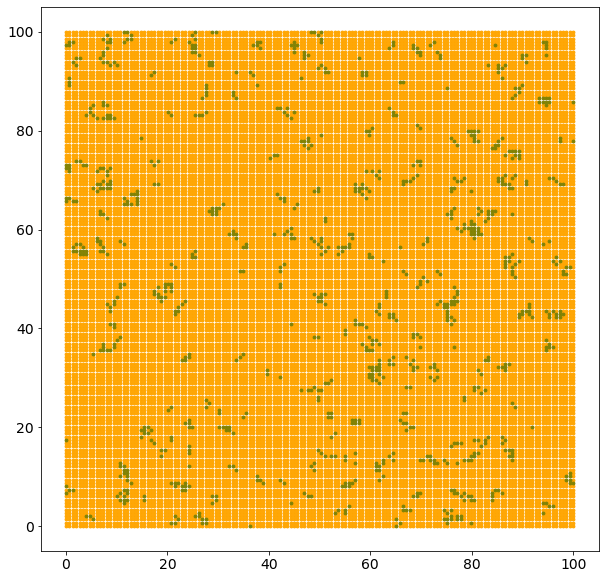

Number of islands is:
[1, 3, 4, 7, 8, 1, 3, 4, 2, 3, 1, 4, 4, 10, 4, 1, 2, 11, 6, 3, 4, 4, 10, 7, 11, 4, 2, 7, 2, 3, 3, 7, 1, 1, 8, 2, 1, 2, 3, 7, 7, 1, 3, 2, 3, 1, 2, 4, 4, 2, 3, 1, 2, 2, 8, 2, 7, 6, 5, 1, 6, 2, 4, 2, 2, 2, 3, 2, 2, 2, 2, 1, 5, 3, 2, 3, 18, 3, 1, 2, 2, 5, 4, 6, 4, 5, 3, 3, 1, 1, 10, 5, 6, 1, 1, 5, 2, 4, 2, 3, 5, 1, 22, 5, 10, 10, 6, 4, 6, 8, 8, 3, 7, 3, 2, 5, 6, 2, 2, 5, 2, 3, 2, 7, 4, 1, 4, 3, 12, 8, 9, 7, 3, 1, 2, 3, 1, 2, 1, 5, 6, 3, 19, 1, 2, 7, 4, 5, 9, 3, 1, 2, 5, 7, 5, 4, 11, 12, 3, 3, 1, 10, 2, 6, 2, 5, 4, 4, 2, 6, 5, 1, 4, 3, 4, 3, 9, 7, 6, 3, 9, 2, 1, 1, 1, 4, 2, 6, 6, 6, 2, 4, 4, 1, 3, 9, 1, 5, 3, 6, 1, 3, 1, 2, 1, 1, 2, 2, 4, 1, 5, 5, 4, 9, 4, 1, 4, 4, 1, 3, 8, 6, 1, 6, 5, 3, 4, 4, 2, 1, 5, 6, 2, 6, 3, 2]


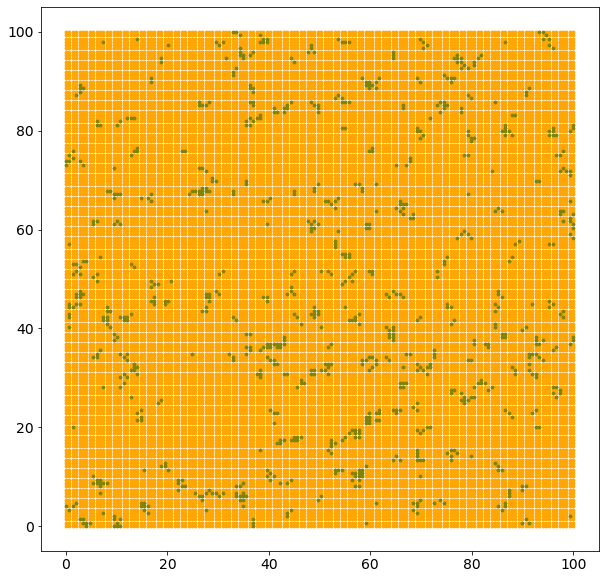

Number of islands is:
[6, 7, 3, 1, 3, 3, 1, 1, 7, 6, 4, 1, 4, 1, 1, 1, 2, 10, 8, 2, 3, 1, 6, 3, 9, 3, 2, 1, 2, 5, 12, 1, 4, 1, 4, 4, 3, 6, 6, 1, 6, 1, 4, 6, 10, 5, 1, 2, 1, 7, 5, 2, 3, 3, 3, 4, 2, 3, 2, 8, 1, 6, 3, 2, 1, 2, 4, 5, 5, 3, 4, 4, 6, 2, 4, 7, 8, 3, 9, 1, 5, 1, 4, 3, 2, 2, 6, 4, 3, 1, 4, 2, 14, 2, 2, 3, 2, 5, 3, 3, 9, 4, 2, 2, 1, 6, 1, 2, 1, 6, 2, 6, 2, 2, 2, 2, 7, 3, 3, 3, 3, 5, 1, 3, 3, 4, 3, 1, 5, 3, 6, 2, 4, 3, 2, 4, 4, 6, 3, 1, 1, 6, 2, 2, 2, 3, 1, 1, 2, 3, 2, 2, 1, 5, 3, 1, 2, 2, 5, 2, 7, 1, 4, 5, 3, 3, 1, 1, 3, 8, 3, 1, 1, 3, 6, 3, 3, 1, 6, 1, 11, 2, 2, 1, 3, 4, 2, 1, 3, 2, 5, 3, 1, 1, 6, 2, 1, 3, 4, 2, 3, 2, 3, 5, 5, 7, 6, 3, 2, 3, 2, 8, 3, 1, 2, 3, 5, 5, 7, 2, 2, 5, 3, 6, 1, 2, 5, 3, 4, 10, 2, 2, 5, 3, 9, 4, 2, 2, 1, 5, 3, 2, 4, 4, 2, 1, 3, 1, 6, 4, 1, 1, 5, 3]


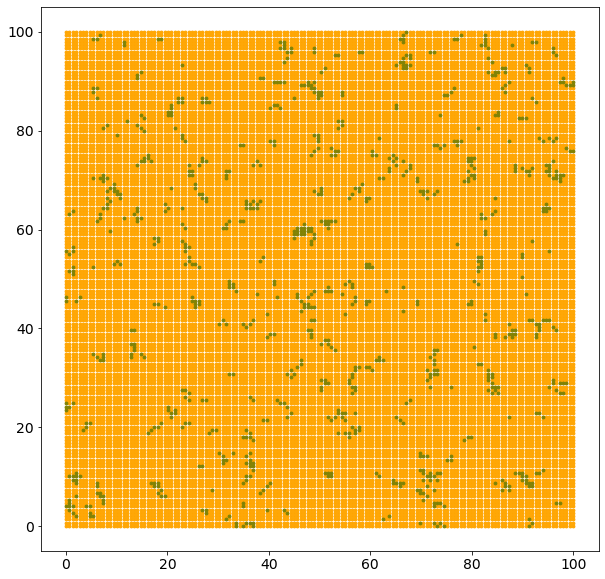

Number of islands is:
[2, 5, 4, 3, 1, 2, 1, 8, 3, 1, 3, 2, 1, 2, 2, 5, 6, 2, 6, 1, 9, 4, 1, 1, 6, 2, 6, 1, 12, 8, 4, 1, 12, 5, 2, 3, 9, 2, 5, 3, 4, 1, 6, 3, 3, 5, 3, 1, 5, 4, 3, 3, 2, 9, 6, 2, 1, 3, 1, 5, 4, 2, 5, 2, 2, 11, 14, 3, 6, 1, 1, 3, 3, 8, 4, 2, 3, 3, 6, 2, 6, 4, 6, 2, 6, 1, 3, 4, 2, 7, 11, 2, 2, 4, 3, 1, 2, 1, 1, 1, 1, 10, 1, 1, 7, 2, 3, 3, 2, 3, 2, 2, 1, 3, 1, 1, 1, 6, 4, 1, 4, 1, 2, 2, 1, 4, 8, 1, 6, 5, 3, 2, 2, 4, 5, 1, 4, 21, 1, 1, 2, 1, 2, 4, 8, 3, 6, 2, 1, 3, 2, 2, 3, 6, 5, 1, 10, 5, 3, 9, 2, 5, 1, 5, 2, 4, 1, 2, 5, 2, 7, 15, 1, 4, 2, 4, 4, 5, 2, 3, 7, 7, 1, 4, 3, 5, 1, 3, 5, 3, 3, 4, 2, 3, 4, 3, 4, 1, 2, 3, 1, 1, 3, 2, 1, 4, 1, 1, 2, 3, 6, 1, 3, 4, 2, 4, 5, 2, 1, 1, 14, 2, 4, 3, 4, 7, 4, 3, 2, 8, 2, 3, 12, 1, 2, 2, 2, 3, 8, 2, 2, 2, 6, 2, 1, 5, 2, 3, 2, 3]


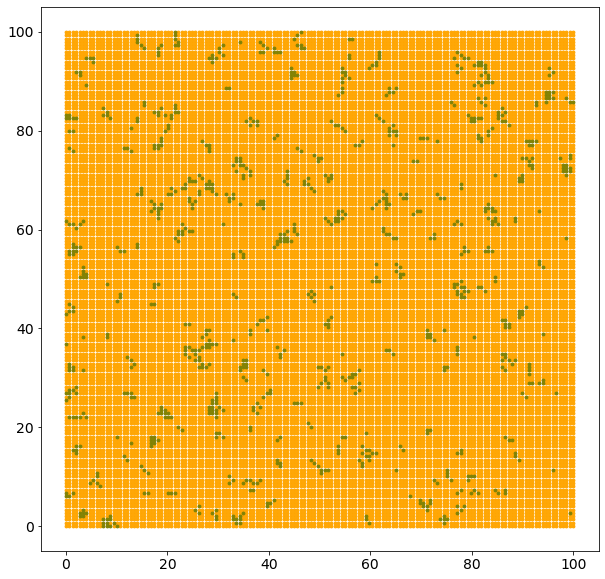

Number of islands is:
[11, 8, 3, 5, 4, 6, 3, 4, 1, 8, 4, 4, 1, 2, 3, 2, 3, 2, 2, 2, 6, 3, 6, 2, 4, 4, 3, 7, 1, 1, 4, 3, 2, 9, 3, 5, 3, 3, 2, 8, 1, 2, 3, 1, 4, 2, 1, 3, 2, 2, 2, 6, 10, 17, 5, 3, 8, 5, 4, 2, 5, 1, 6, 2, 3, 2, 7, 2, 4, 5, 1, 8, 4, 3, 2, 4, 25, 7, 3, 1, 3, 3, 1, 1, 1, 6, 1, 2, 4, 1, 2, 1, 1, 1, 5, 6, 2, 4, 6, 5, 2, 3, 5, 2, 13, 3, 3, 1, 1, 4, 2, 7, 6, 3, 1, 2, 3, 9, 4, 3, 4, 2, 13, 10, 6, 3, 1, 4, 6, 1, 12, 3, 6, 2, 10, 3, 7, 1, 5, 6, 11, 1, 5, 4, 3, 4, 4, 2, 9, 6, 7, 2, 5, 5, 5, 2, 2, 10, 1, 9, 1, 7, 4, 2, 1, 2, 2, 3, 5, 2, 7, 3, 1, 6, 1, 4, 2, 3, 7, 3, 2, 3, 5, 1, 6, 9, 2, 3, 7, 6, 5, 6, 4, 1, 2, 2, 4, 2, 9, 3, 3, 5, 2, 1, 17, 7, 7, 3, 3, 3, 7, 4, 5, 2, 1, 4, 4, 4, 5, 4, 5, 4, 6, 1, 3, 2]


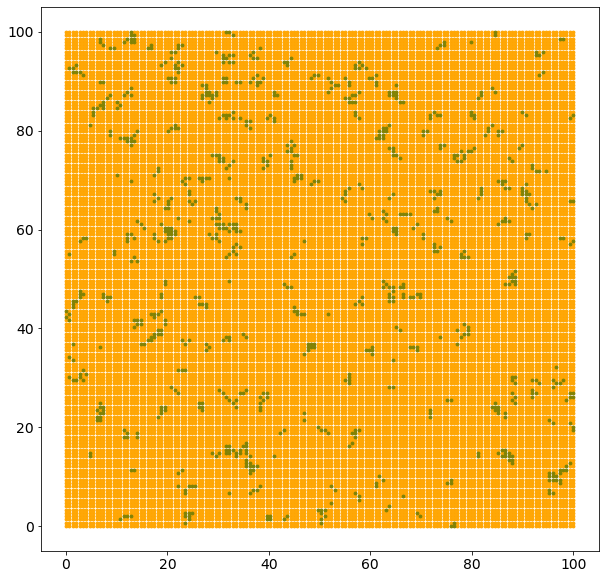

Number of islands is:
[3, 7, 7, 4, 4, 2, 2, 2, 1, 3, 1, 5, 1, 4, 3, 2, 1, 2, 3, 16, 2, 2, 27, 2, 12, 2, 3, 1, 2, 2, 4, 2, 5, 2, 4, 3, 2, 11, 1, 6, 3, 2, 1, 7, 5, 8, 7, 4, 2, 5, 4, 3, 3, 2, 5, 5, 4, 3, 8, 3, 1, 2, 1, 8, 5, 3, 4, 1, 1, 11, 3, 1, 4, 2, 1, 6, 2, 1, 6, 2, 4, 5, 6, 1, 8, 4, 4, 5, 11, 2, 2, 2, 5, 3, 3, 2, 10, 1, 3, 7, 2, 5, 1, 2, 5, 1, 2, 3, 5, 3, 14, 5, 1, 2, 2, 3, 2, 5, 14, 3, 2, 5, 1, 4, 2, 1, 6, 2, 4, 3, 5, 2, 12, 3, 3, 3, 5, 2, 2, 6, 4, 2, 2, 6, 4, 3, 1, 5, 6, 1, 1, 3, 4, 1, 3, 5, 3, 7, 11, 2, 6, 1, 8, 3, 2, 10, 11, 2, 3, 4, 3, 5, 4, 1, 4, 7, 1, 3, 5, 4, 2, 10, 2, 3, 14, 8, 9, 3, 4, 3, 6, 2, 7, 3, 5, 1, 2, 5, 4, 2, 3, 7, 2, 6, 6, 2, 4, 8, 1, 4, 4, 5, 1, 2, 3, 1, 4, 3, 9, 1, 2, 3, 2]


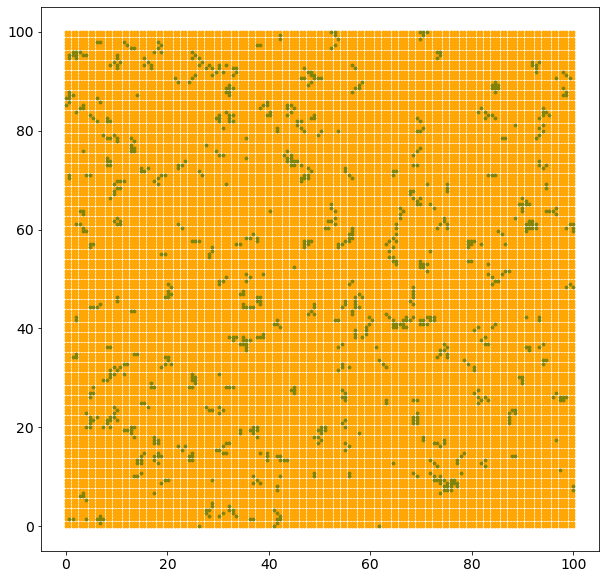

Number of islands is:
[1, 7, 1, 5, 2, 1, 2, 6, 2, 5, 4, 1, 22, 2, 2, 3, 4, 1, 3, 1, 2, 2, 2, 1, 1, 3, 3, 6, 6, 1, 4, 5, 3, 5, 2, 7, 1, 3, 3, 5, 5, 10, 2, 1, 7, 7, 2, 1, 8, 11, 3, 7, 7, 3, 3, 3, 2, 7, 5, 2, 7, 3, 4, 1, 3, 8, 3, 4, 11, 1, 1, 3, 2, 6, 1, 3, 2, 3, 3, 8, 2, 9, 3, 2, 2, 1, 2, 4, 4, 4, 3, 7, 2, 4, 16, 2, 10, 2, 2, 2, 1, 5, 9, 2, 4, 5, 3, 5, 6, 2, 7, 3, 3, 4, 2, 5, 3, 1, 3, 7, 1, 5, 1, 2, 4, 2, 2, 1, 3, 6, 11, 6, 2, 5, 1, 1, 3, 5, 2, 5, 11, 5, 2, 2, 2, 6, 5, 4, 4, 1, 3, 5, 1, 3, 8, 2, 8, 9, 3, 2, 5, 1, 1, 8, 2, 4, 2, 2, 3, 3, 4, 4, 4, 5, 12, 2, 1, 3, 3, 1, 7, 1, 6, 1, 2, 5, 2, 2, 5, 1, 3, 1, 1, 3, 3, 4, 6, 2, 3, 7, 6, 3, 6, 4, 4, 7, 2, 1, 7, 4, 5, 8, 10, 2, 3, 2, 1, 3, 8, 4, 6, 7, 5, 2, 6, 1, 10, 4, 5, 4, 2, 2, 2, 2, 4, 5]


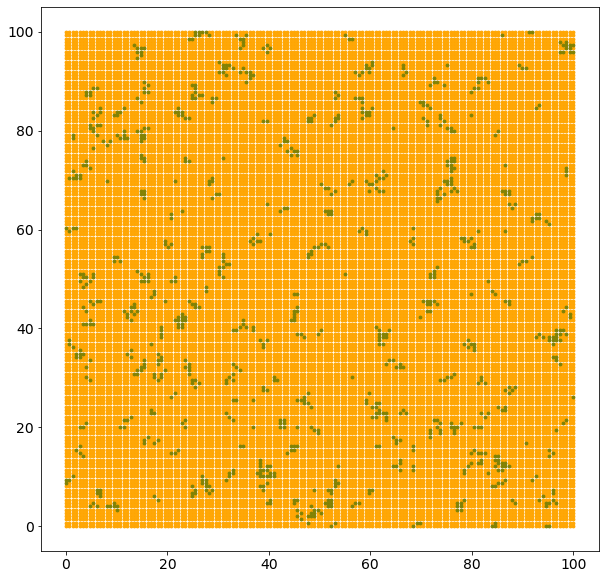

Number of islands is:
[2, 3, 3, 2, 1, 4, 9, 6, 7, 3, 7, 3, 5, 3, 3, 2, 2, 2, 5, 5, 10, 7, 3, 2, 4, 1, 5, 4, 5, 2, 17, 4, 1, 5, 2, 13, 1, 3, 4, 3, 3, 6, 5, 2, 2, 2, 3, 2, 4, 1, 3, 4, 6, 7, 1, 3, 2, 3, 1, 6, 1, 3, 2, 3, 3, 13, 3, 3, 3, 4, 8, 2, 2, 1, 2, 1, 1, 5, 3, 5, 5, 4, 2, 6, 3, 5, 1, 8, 6, 3, 1, 4, 5, 3, 4, 1, 6, 3, 7, 3, 4, 1, 12, 14, 4, 3, 3, 2, 6, 2, 12, 5, 10, 7, 1, 2, 2, 2, 2, 5, 4, 7, 3, 1, 3, 2, 1, 2, 2, 10, 8, 3, 1, 10, 6, 1, 3, 4, 7, 9, 1, 4, 3, 6, 3, 5, 1, 4, 4, 1, 1, 1, 2, 6, 2, 5, 1, 3, 3, 1, 7, 5, 3, 2, 5, 1, 12, 9, 3, 4, 2, 1, 1, 7, 3, 10, 4, 1, 4, 3, 1, 6, 1, 3, 4, 9, 2, 6, 7, 2, 4, 1, 5, 3, 4, 2, 5, 5, 8, 8, 5, 1, 5, 2, 2, 3, 4, 9, 3, 6, 5, 3, 4, 1, 8, 5, 10, 9, 4, 3, 1, 8, 4, 12, 7, 9, 3, 1, 2]


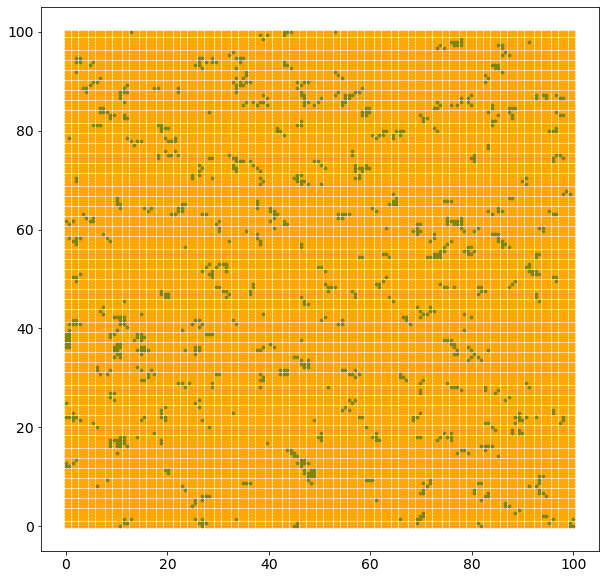

Number of islands is:
[5, 6, 3, 2, 4, 6, 2, 1, 1, 2, 2, 3, 3, 4, 1, 4, 9, 7, 2, 2, 1, 1, 3, 25, 2, 1, 3, 3, 5, 1, 1, 4, 5, 15, 2, 1, 4, 5, 7, 1, 2, 1, 2, 3, 4, 2, 1, 1, 7, 3, 7, 2, 6, 1, 1, 4, 2, 1, 1, 2, 3, 3, 1, 3, 4, 2, 2, 2, 5, 2, 4, 2, 1, 1, 2, 2, 6, 4, 4, 7, 3, 2, 2, 6, 2, 9, 7, 11, 7, 5, 9, 1, 3, 1, 11, 2, 7, 1, 4, 3, 1, 1, 9, 5, 6, 2, 3, 4, 2, 8, 1, 3, 1, 1, 1, 4, 1, 2, 3, 6, 6, 3, 4, 5, 5, 5, 3, 1, 3, 4, 3, 10, 9, 3, 3, 2, 3, 13, 3, 7, 1, 2, 10, 6, 4, 3, 1, 3, 7, 4, 1, 13, 2, 3, 1, 1, 3, 3, 5, 7, 6, 8, 2, 2, 3, 3, 2, 3, 5, 3, 7, 3, 2, 3, 3, 9, 1, 3, 2, 2, 1, 12, 4, 10, 4, 4, 4, 5, 2, 2, 5, 2, 2, 5, 5, 1, 6, 6, 4, 6, 2, 4, 3, 3, 3, 4, 8, 3, 6, 7, 1, 3, 1, 3, 4, 2, 7, 12, 3, 11, 1, 3, 4, 8, 2, 3, 3, 2, 7, 2, 13, 2, 3, 3, 1, 6, 7, 1, 4, 2, 4, 3, 4, 2, 6, 3, 8, 1, 3, 4, 1, 1]


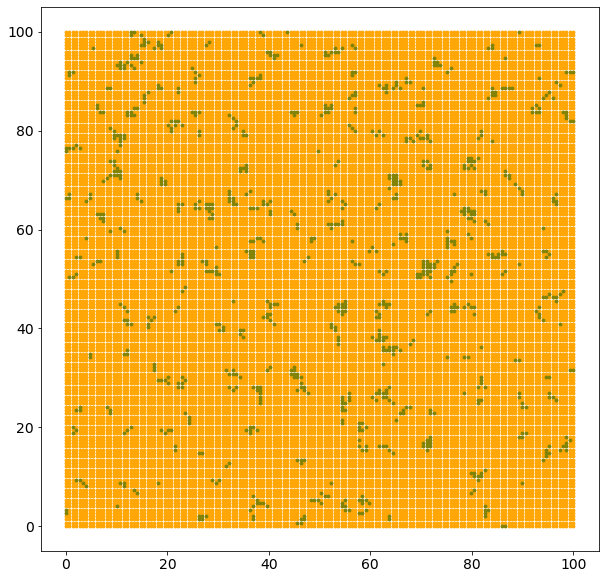

Number of islands is:
[2, 5, 5, 2, 2, 5, 2, 3, 8, 6, 1, 4, 6, 3, 2, 2, 4, 3, 1, 3, 1, 1, 8, 2, 4, 6, 2, 5, 2, 4, 10, 7, 1, 4, 3, 3, 4, 6, 6, 4, 2, 1, 3, 5, 3, 3, 10, 3, 9, 13, 3, 4, 2, 6, 1, 3, 6, 5, 5, 6, 9, 2, 3, 2, 2, 1, 2, 2, 1, 2, 3, 10, 1, 3, 2, 9, 4, 5, 4, 5, 4, 6, 1, 5, 4, 12, 2, 1, 3, 2, 6, 5, 6, 4, 1, 8, 2, 7, 3, 21, 7, 3, 1, 2, 1, 3, 6, 3, 3, 1, 2, 2, 3, 7, 9, 4, 3, 1, 7, 1, 5, 3, 1, 6, 1, 2, 1, 2, 1, 2, 7, 1, 2, 6, 13, 10, 2, 2, 4, 4, 3, 3, 2, 8, 4, 5, 3, 3, 5, 3, 3, 2, 1, 3, 4, 13, 5, 14, 4, 6, 6, 11, 2, 6, 1, 1, 11, 4, 7, 1, 3, 2, 3, 4, 8, 3, 5, 6, 7, 4, 4, 8, 4, 2, 6, 4, 4, 4, 6, 3, 1, 2, 5, 2, 3, 4, 1, 4, 7, 2, 5, 3, 1, 3, 3, 2, 3, 15, 6, 6, 1, 8, 1, 5, 2, 3, 6, 2, 1, 2, 3, 2, 2, 1, 1]


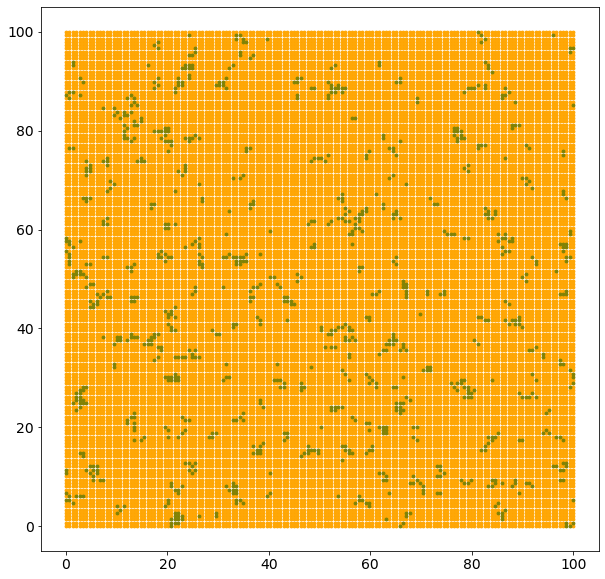

Number of islands is:
[13, 2, 4, 1, 5, 1, 2, 3, 4, 3, 7, 2, 5, 4, 1, 3, 2, 1, 6, 9, 1, 8, 2, 1, 5, 3, 3, 4, 1, 10, 2, 5, 2, 6, 2, 7, 1, 7, 1, 3, 9, 8, 6, 4, 9, 1, 2, 4, 2, 2, 3, 1, 3, 4, 7, 3, 3, 2, 1, 1, 2, 5, 2, 3, 5, 2, 9, 2, 17, 6, 3, 2, 16, 6, 4, 6, 6, 2, 2, 10, 3, 1, 1, 1, 1, 3, 2, 1, 5, 2, 1, 1, 1, 3, 2, 4, 6, 2, 2, 3, 3, 4, 3, 1, 2, 5, 9, 8, 2, 5, 5, 1, 3, 10, 4, 2, 3, 9, 3, 1, 3, 4, 7, 1, 12, 7, 2, 5, 3, 8, 3, 3, 2, 3, 4, 4, 3, 1, 2, 3, 3, 8, 2, 4, 3, 1, 6, 5, 2, 14, 3, 3, 8, 3, 2, 1, 4, 6, 5, 1, 5, 3, 1, 1, 8, 2, 1, 15, 4, 2, 1, 4, 4, 1, 3, 2, 7, 5, 8, 1, 3, 4, 2, 2, 4, 2, 4, 1, 3, 1, 4, 1, 1, 1, 1, 4, 1, 2, 2, 7, 5, 3, 4, 4, 5, 3, 1, 1, 4, 2, 1, 3, 2, 4, 2, 13, 8, 6, 1, 11, 2, 4, 5, 5, 2, 3, 1, 6, 1, 2, 1, 4, 2, 13, 5, 1, 7, 5, 4, 7, 2, 2, 2, 4, 3, 2, 4, 7, 2, 2, 2, 1, 2, 2, 4, 2, 3, 3, 6, 4, 1, 1, 1]


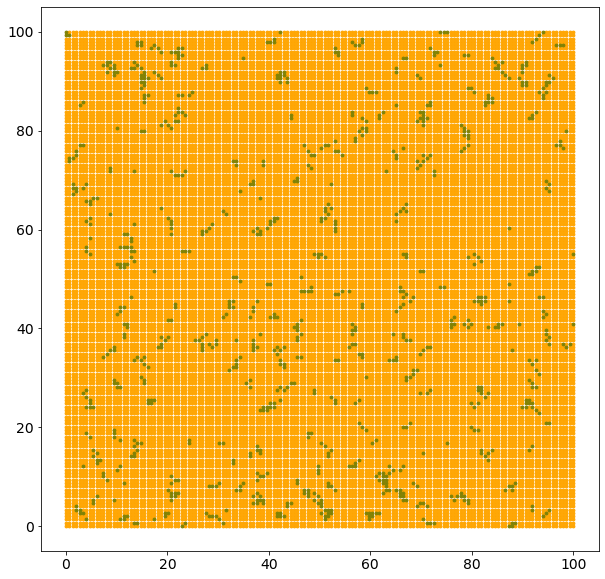

Number of islands is:
[2, 4, 2, 6, 4, 1, 4, 1, 16, 8, 3, 5, 3, 5, 1, 2, 3, 4, 3, 9, 9, 1, 7, 8, 5, 17, 4, 4, 5, 4, 2, 1, 4, 2, 3, 5, 3, 2, 2, 1, 5, 6, 2, 6, 8, 2, 3, 4, 1, 2, 2, 2, 2, 2, 1, 1, 2, 3, 3, 3, 3, 3, 2, 10, 9, 8, 3, 5, 3, 2, 1, 7, 2, 1, 2, 6, 5, 3, 4, 3, 6, 1, 2, 6, 6, 4, 3, 2, 4, 5, 2, 3, 5, 4, 7, 5, 1, 6, 4, 3, 3, 5, 1, 8, 4, 2, 1, 5, 1, 3, 5, 4, 1, 4, 1, 1, 2, 2, 1, 4, 3, 4, 2, 3, 2, 5, 2, 8, 1, 2, 1, 1, 5, 2, 3, 5, 1, 2, 2, 1, 3, 1, 6, 1, 2, 6, 1, 2, 3, 5, 3, 1, 3, 1, 6, 3, 4, 1, 1, 5, 5, 4, 4, 6, 1, 3, 1, 8, 1, 1, 2, 5, 1, 5, 1, 5, 1, 4, 2, 3, 1, 3, 5, 2, 2, 1, 1, 2, 7, 3, 2, 5, 3, 3, 3, 3, 3, 1, 4, 2, 1, 1, 2, 7, 5, 2, 1, 1, 4, 9, 2, 2, 2, 3, 4, 5, 2, 2, 1, 3, 7, 4, 10, 2, 2, 4, 3, 15, 5, 10, 3, 2, 9, 11, 2, 5, 3, 3, 1, 8, 1, 2, 4, 4, 2, 4, 4, 5, 3, 4, 4, 3, 1, 3]


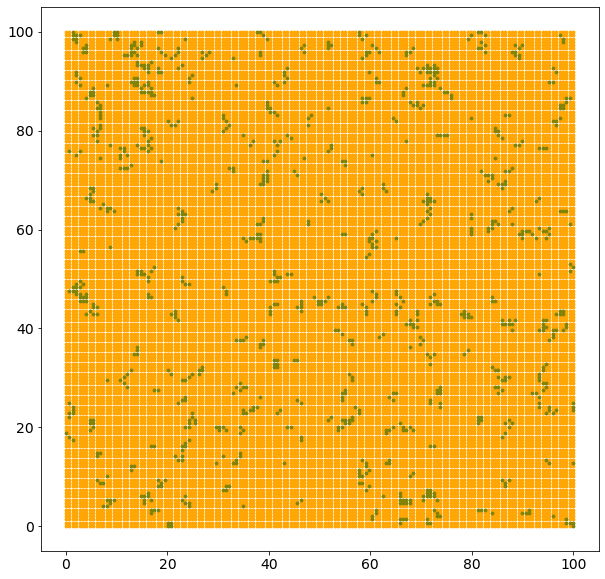

Number of islands is:
[4, 5, 4, 3, 4, 4, 1, 4, 1, 4, 3, 6, 5, 1, 7, 2, 10, 11, 1, 4, 2, 5, 4, 3, 2, 1, 9, 2, 3, 1, 5, 1, 3, 2, 1, 4, 3, 1, 5, 2, 2, 3, 2, 2, 3, 4, 6, 5, 10, 6, 8, 2, 4, 5, 2, 6, 7, 2, 3, 5, 3, 2, 2, 4, 2, 2, 5, 4, 1, 3, 1, 5, 4, 2, 5, 10, 6, 1, 4, 3, 5, 2, 4, 3, 6, 1, 2, 3, 4, 2, 4, 1, 3, 3, 4, 5, 2, 3, 1, 7, 3, 7, 7, 5, 7, 7, 5, 4, 4, 2, 5, 5, 4, 7, 7, 18, 4, 4, 3, 3, 3, 4, 7, 7, 2, 1, 2, 3, 2, 2, 1, 9, 9, 1, 8, 6, 2, 3, 7, 9, 4, 2, 14, 1, 1, 2, 6, 2, 3, 8, 4, 2, 3, 3, 3, 5, 9, 6, 2, 3, 3, 4, 3, 1, 2, 1, 6, 1, 1, 2, 2, 1, 1, 8, 3, 3, 1, 2, 3, 3, 1, 1, 2, 5, 6, 5, 1, 4, 6, 4, 1, 4, 2, 7, 2, 1, 7, 2, 1, 6, 7, 5, 6, 1, 5, 18, 3, 5, 1, 1, 2, 22, 3, 5, 3, 2, 9, 3, 1, 2, 2, 4, 4, 1, 4, 8, 13, 3, 2, 4, 5, 3, 3, 5, 4, 7, 3, 6, 1, 4, 4, 2, 3, 2]


In [937]:
n = 12
all_counts = []
for i in range(n):

    # create initial state
    m_state = State(22500, 100, 1, 'continuous', seed=i*2, pareto=(5, 0.01))
    m_state.populate(seedBySusceptibility, structure='grid')
    #m_state.show(mark=[0, 1], mark_neighbours=[532])

#densities = []
#counter = 1
    nsteps = 500000
    for i in range(nsteps):
        step(m_state, susceptibilitySpreading)

    m_state.show(figsize=(10, 10))
    islands = count_islands(m_state, inverse=False)
    counts = np.bincount(islands)
    all_counts.append(counts)

    


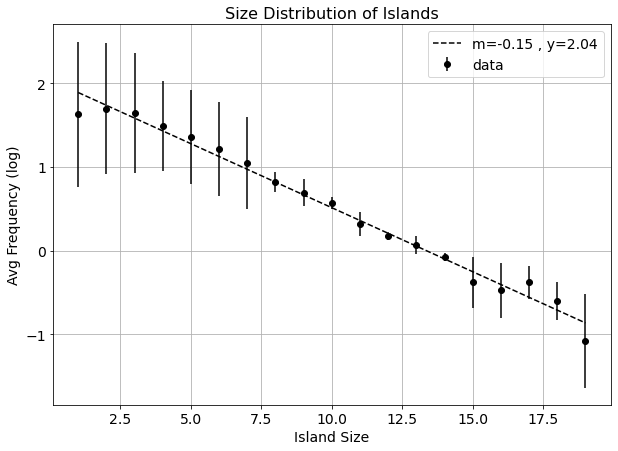

In [938]:
plt.figure(figsize=(10, 7))

k = 0
data = []
kstop = np.max([len(arr) for arr in all_counts])
counting = True
for k in range(1, kstop):
    data.append([arr[k] if len(arr) > k else 0 for arr in all_counts])
    
data = np.array(data)
mean = data.mean(axis=1)
std = data.std(axis=1)

sizes = []
avg_counts = []
avg_counts_std = []
for k in range(1, kstop):
    if mean[k-1] > 0.:
        sizes.append(k)
        avg_counts.append(mean[k-1])
        avg_counts_std.append(std[k-1])
    else: break

avg_counts_log = np.log10(avg_counts)
avg_counts_std_log = np.log10(avg_counts_std)
m, y = np.polyfit(sizes, avg_counts_log, 1)

plt.errorbar(sizes, avg_counts_log, yerr=avg_counts_std_log, fmt='o', ms='6', color='black', label='data')
plt.grid(True)

x = np.linspace(np.min(sizes), np.max(sizes), 10)
plt.plot(x, m*x + y, '--', c='black', label=f'm={m:.2f} , y={y:.2f}')

plt.xlabel('Island Size', fontsize=14)
plt.ylabel('Avg Frequency (log)', fontsize=14)
plt.title(' Size Distribution of Islands ', fontsize=16)
plt.legend(fontsize=14)
plt.show()

# State(22500, 100, 1, 'continuous', seed=i, pareto=(5, 0.01))
# 500 000 steps
# n = 12

In [1070]:
testState = State(22500, 100, 1, 'continuous', seed=0, pareto=(5, 0.1))
testState.susceptibility = np.mean(testState.susceptibility) * np.ones(testState.N)
testState.populate(seedBySusceptibility, structure='grid')

countInstallations = 0
countSGreater05 = 0

325
36


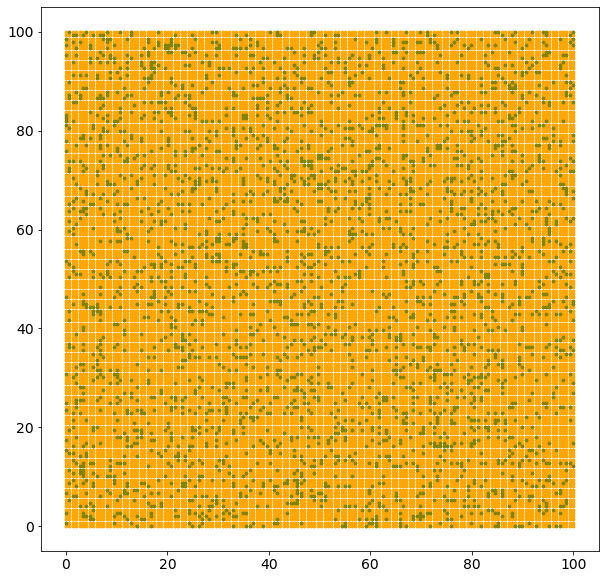

In [ ]:
n = 12
all_counts = []
for i in range(n):

    # create initial state
    m_state = State(22500, 100, 1, 'continuous', seed=i*2, pareto=(5, 0.01))
    m_state.susceptibility = np.mean(m_state.susceptibility) * np.ones(m_state.N)
    m_state.populate(seedBySusceptibility, structure='grid')
    #m_state.show(mark=[0, 1], mark_neighbours=[532])

#densities = []
#counter = 1
    nsteps = 500000
    for i in range(nsteps):
        step(m_state, susceptibilitySpreading)

    m_state.show(figsize=(10, 10))
    islands = count_islands(m_state, inverse=False)
    counts = np.bincount(islands)
    all_counts.append(counts)

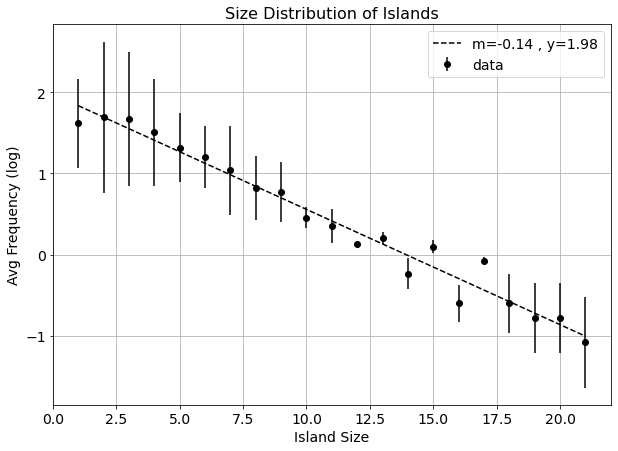

In [940]:
plt.figure(figsize=(10, 7))

k = 0
data = []
kstop = np.max([len(arr) for arr in all_counts])
counting = True
for k in range(1, kstop):
    data.append([arr[k] if len(arr) > k else 0 for arr in all_counts])
    
data = np.array(data)
mean = data.mean(axis=1)
std = data.std(axis=1)

sizes = []
avg_counts = []
avg_counts_std = []
for k in range(1, kstop):
    if mean[k-1] > 0.:
        sizes.append(k)
        avg_counts.append(mean[k-1])
        avg_counts_std.append(std[k-1])
    else: break

avg_counts_log = np.log10(avg_counts)
avg_counts_std_log = np.log10(avg_counts_std)
m, y = np.polyfit(sizes, avg_counts_log, 1)

plt.errorbar(sizes, avg_counts_log, yerr=avg_counts_std_log, fmt='o', ms='6', color='black', label='data')
plt.grid(True)

x = np.linspace(np.min(sizes), np.max(sizes), 10)
plt.plot(x, m*x + y, '--', c='black', label=f'm={m:.2f} , y={y:.2f}')

plt.xlabel('Island Size', fontsize=14)
plt.ylabel('Avg Frequency (log)', fontsize=14)
plt.title(' Size Distribution of Islands ', fontsize=16)
plt.legend(fontsize=14)
plt.show()

# State(22500, 100, 1, 'continuous', seed=i, pareto=(5, 0.01))
# 500 000 steps
# n = 12

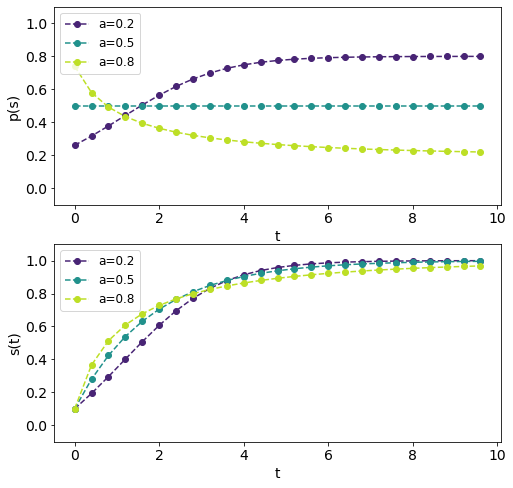

In [610]:
# Master equation
# ---------------
import numpy as np
import matplotlib.pyplot as plt


def model(s0, a):
    p = lambda s, a: (1 - a) * s + a * (1 - s)
    
    s_timeline = [s0]
    p_timeline = []

    tmax = 10
    dt = .4 # in days
    t = np.arange(0, tmax, dt)
    s_current = s0
    for _ in t[1:]:
        # calculate new state
        p_new = p(s_current, a)
        ds = p_new * (1 - s_current)
        s_new = s_current + ds * dt
        s_timeline.append(s_new)
        p_timeline.append(p_new)

        # update state
        s_current = s_new

    p_timeline.append(p(s_current, a))
    
    return t, s_timeline, p_timeline

# Visualize master equation for
# different s0, a
fig, ax = plt.subplots(2, 1, figsize=(8, 8))

s0 = (0.1, 0.1, 0.1)
a = (0.2, 0.5, 0.8)
cmap = mpl.cm.get_cmap('viridis')
color = (cmap(0.1), cmap(0.5), cmap(0.9))

for s0_, a_, color_ in zip(s0, a, color):
    t, s, p = model(s0_, a_)

    label = f'a={a_:.1f}'
    ax[0].plot(t, p, 'o--', ms='6', color=color_, label=label)
    ax[1].plot(t, s, 'o--', ms='6', color=color_, label=label)

ax[0].set_ylabel('p(s)', fontsize=14)
ax[1].set_ylabel('s(t)', fontsize=14)
[axis.set_xlabel('t', fontsize=14) for axis in ax]
[axis.set_ylim([-0.1, 1.1]) for axis in ax]
[axis.legend(fontsize=12, loc='best') for axis in ax]

plt.show()

In [819]:
# Agent Based approach
# --------------------
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt
from dataclasses import dataclass
from scipy.spatial.distance import cdist

mpl.rcParams.update({'font.size': 14})

STATE_SUSCEPTIBLE = 0
STATE_ADOPTED = 1

rng = np.random.default_rng(seed=101)

# agent
@dataclass
class Agent:
    index: int
    state: int
    x: float
    y: float
    neighbours: list[int] # indices of neighburs
        

@dataclass
class BState:
    N: int
    L: float
    agents: list[Agent]
    time: int
        
        
def create_neighbours(rng, N, n_neighbours, locs=None, modus='random', weight_fun=lambda x: np.ones(x.size)): # modus: {'random', 'weighted'}
    if n_neighbours >= N:
        raise Exception(' More neighbours required than points given. ')
    neighbours = [[] for _ in range(N)]
    
    possible_matches = np.arange(N) # all indices
    match_counter = np.zeros(N)
    
    for k, kneighbours in enumerate(neighbours):
        # IF neighbour is missing
        while len(kneighbours) < n_neighbours:
            indices = np.delete(possible_matches, np.where(possible_matches == k))
            for m in kneighbours:
                indices = np.delete(indices, np.where(indices == m))
            if len(indices) < 1:
                break
            
            if modus == 'random':
                # choose random neighbour
                new_neighbour = rng.choice(indices, size=1)[0]
            elif modus == 'weighted':
                # choose neighbour with proximity weights
                # get dist to all possible matches
                distances = cdist([locs[k]], locs[indices])[0]
                new_neighbour = rng.choice(indices, size=1, p=weight_fun(distances))[0]
            else: 
                raise Exception('Choose a valid modus for creating neighbours!')
                
            kneighbours.append(new_neighbour)
            # if a is neighbour of b -> b is neighbour of a
            neighbours[new_neighbour].append(k)
            # update counts
            match_counter[new_neighbour] += 1
            match_counter[k] += 1
            # check possible neighbours
            filled = np.extract(match_counter >= n_neighbours, np.arange(N))
            for j in filled:
                possible_matches = np.delete(possible_matches, np.where(possible_matches == j))
    return neighbours
        
def create_state(N, L, n_neighbours, modus, weight_fun):
    locs = rng.random((N, 2)) * L
    n_neighbours = n_neighbours
    # choose random neighbours
    neighbours = create_neighbours(rng, N, n_neighbours, locs, modus=modus, weight_fun=weight_fun)
    agents = [Agent(i, STATE_SUSCEPTIBLE, locs[i, 0], locs[i, 1], neighbours[i]) for i in range(N)]
    state = BState(N, L, agents, 0)
    return state
    
def array_repr(state: BState):
    """Returns the array representation of the state (locs, microstates)."""
    locs, microstates = [], []
    for agent in state.agents:
        locs.append([agent.x, agent.y])
        microstates.append(agent.state)
    return np.array(locs), np.array(microstates), [agent.neighbours for agent in state.agents]
    
def show(state: BState):
    fig = plt.figure(figsize=(6, 6))
    
    locs, microstates, neighbours = array_repr(state)
    colors = {
        STATE_SUSCEPTIBLE: '#000', 
        STATE_ADOPTED: '#2d2'
    }
    ms_as_text = {
        STATE_SUSCEPTIBLE: "Susceptible", 
        STATE_ADOPTED: "Adopted"
    }
        
    # plot neighbours
    for k, kneighbours in enumerate(neighbours):
        x0, y0 = locs[k]
        for index in kneighbours:
            x1, y1 = locs[index]
            plt.plot([x0, x1], [y0, y1], '--', color='#dd212121')
    
    for ms in (STATE_SUSCEPTIBLE, STATE_ADOPTED):
        x = locs[:, 0][microstates == ms]
        y = locs[:, 1][microstates == ms]
        plt.scatter(x, y, c=colors[ms], s=24, label=ms_as_text[ms])
    
    plt.show()
    
    
def step(state: BState, a):
    p = lambda s: ((1 - a) * s + a * (1 - s))**2
    state.time += 1
    planted = np.array([], dtype='int32')
    for agent in state.agents:
        if agent.state == STATE_ADOPTED:
            neighbours = agent.neighbours
            # IF global s
            #s_current = np.sum([agent.state for agent in state.agents]) * 1. / state.N
            for k in neighbours:
                neighbour_agent = state.agents[k]
                if neighbour_agent.state == STATE_ADOPTED: continue
                kneighbours = state.agents[k].neighbours
                s = np.sum([state.agents[m].state for m in kneighbours]) * 1. / len(kneighbours)
                # spread to neighbours with probability p
                if rng.random() < p(s):
                    planted = np.append(planted, k)
    n_new = 0
    for k in np.unique(planted):
        state.agents[k].state = STATE_ADOPTED
        n_new += 1
    return n_new
    

def plant(state: BState, rho0):
    # choose a agent
    pioneers = rng.choice(state.agents, size=int(state.N * rho0))
    for agent in pioneers:
        agent.state = STATE_ADOPTED

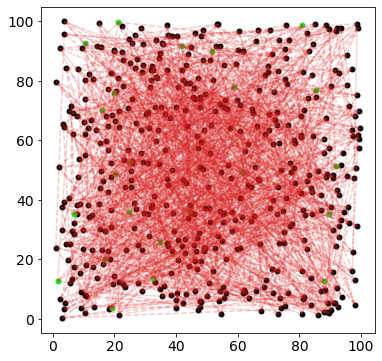

State after 8 days


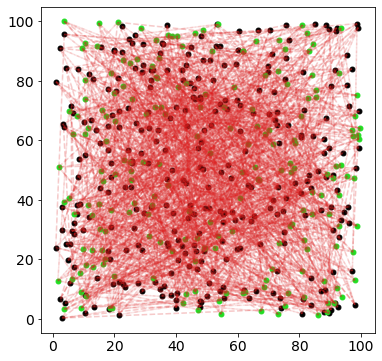

0.394


In [820]:
def exp_weight(x: np.ndarray):
    # e^-x^2
    weights = np.exp(-np.power(x/10, 4))
    # normalize that weights sum up to one
    s = np.sum(weights)
    threshold = 1e-20
    if s < threshold:
        return np.ones(x.size) / x.size
    weights = weights / s
    return weights
    

state = create_state(500, 100, 5, 'random', weight_fun=exp_weight)
plant(state, 0.05)
show(state)

days = 8
for d in range(days):
    step(state, 0.1)
    
print(f'State after {days} days')
show(state)

s_current = np.sum([agent.state for agent in state.agents]) * 1. / state.N
print(s_current)

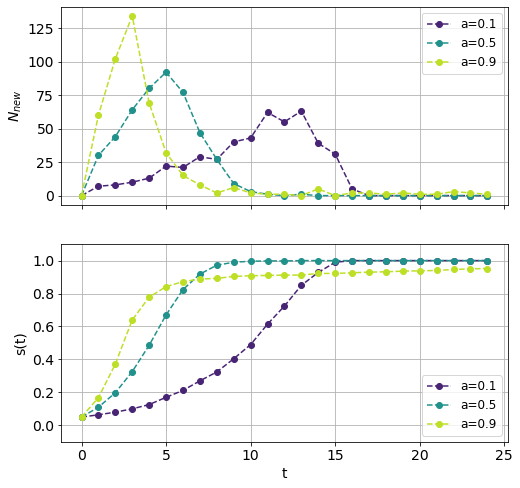

In [827]:
def ABM(s0, a):
    state = create_state(500, 100, n_neighbours=5, weight_fun=exp_weight, modus='random')
    plant(state, s0)
    
    tmax = 25
    dt = 1.# in days
    t = np.arange(0, tmax, dt)
    s_current = s0
    s, p = [s0], [0.]
    for _ in t[1:]:
        p_current = step(state, a)
        s_current = np.sum([agent.state for agent in state.agents]) * 1. / state.N
        s.append(s_current)
        p.append(p_current)
    return t, s, p

# Visualize master equation for
# different s0, a
fig, ax = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

s0 = (0.05, 0.05, 0.05)
a = (0.1, 0.5, 0.9)

cmap = mpl.cm.get_cmap('viridis')
color = (cmap(0.1), cmap(0.5), cmap(0.9))

for s0_, a_, color_ in zip(s0, a, color):
    t, s, p = ABM(s0_, a_)

    label = f'a={a_:.1f}'
    ax[0].plot(t, p, 'o--', ms='6', color=color_, label=label)
    ax[1].plot(t, s, 'o--', ms='6', color=color_, label=label)

ax[0].set_ylabel(r'$N_{new}$')
ax[1].set_ylabel('s(t)')
[axis.set_xlabel('t') for axis in ax[1:]]
[axis.grid(True) for axis in ax]
ax[1].set_ylim([-0.1, 1.1])
[axis.legend(fontsize=12, loc='best') for axis in ax]

plt.show()

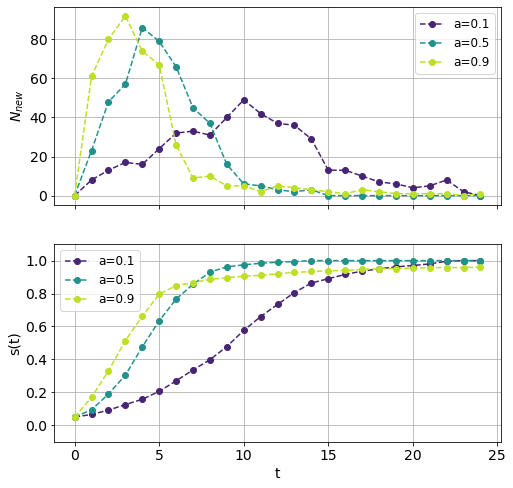

In [826]:
# exp weight
fig

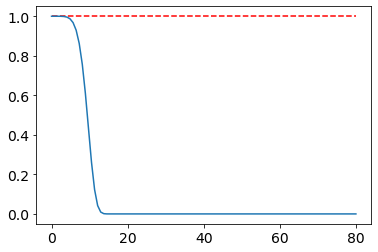

In [739]:
def exp_weight(x: np.ndarray):
    # e^-x^2
    weights = np.exp(-np.power(x/10, 6))
    # normalize that weights sum up to one
    return weights
    s = np.sum(weights)
    threshold = 1e-20
    if s < threshold:
        return np.ones(x.size) / x.size
    weights = weights / s
    return weights

x = np.linspace(0, 80, 100)
plt.plot(x, np.ones(x.size),'r--')
plt.plot(x, exp_weight(x))
plt.show()

1.0